In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math

In [3]:
from utils_custom import *

In [4]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [5]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

# LF dynamics

In [6]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11_GC_PB.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3_GC_PB.txt'
# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)
# remove HLA- genes
z11 = z11[~z11['names'].str.contains('HLA-')]
z3 = z3[~z3['names'].str.contains('HLA-')]

In [7]:
# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()
# create a list of all lf genes 
lf_genes = list(set(z11_genes + z3_genes))
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])


Found 57 genes
Missing 0 genes
Indices: {'HSP90B1': 4304, 'IRF4': 4652, 'SLC25A13': 9042, 'SLAMF7': 8987, 'CEP128': 1733, 'SUB1': 9706, 'IGHM': 4421, 'RNF213': 8355, 'PIM2': 7239, 'PIKFYVE': 7235, 'CTSH': 2270, 'CD99': 1598, 'FNDC3B': 3517, 'CDK6': 1665, 'XBP1': 11200, 'TXNDC5': 10727, 'ARNTL2': 665, 'SLA': 8982, 'IQGAP2': 4638, 'TRAM1': 10472, 'DEK': 2479, 'HM13': 4210, 'CD79A': 1587, 'SSR1': 9582, 'PAX5': 6943, 'AFF3': 230, 'CCSER2': 1534, 'FNDC3A': 3516, 'TIAM1': 10070, 'TRAM2': 10473, 'BTG2': 1106, 'ARFGAP3': 560, 'JCHAIN': 4730, 'SEL1L3': 8763, 'ANKRD28': 429, 'CPEB4': 2131, 'TBC1D4': 9887, 'GAB1': 3613, 'CD74': 1586, 'PDE4D': 7027, 'MZB1': 6199, 'ELL2': 2979, 'MAPK1': 5543, 'RUNX2': 8586, 'EEA1': 2862, 'GLCCI1': 3767, 'TXNDC11': 10722, 'MED23': 5675, 'CIITA': 1884, 'UBAC2': 10759, 'PRDM1': 7604, 'B2M': 872, 'PPIB': 7507, 'LMAN1': 5269, 'TNFAIP8': 10337, 'MAN1A1': 5488, 'CD52': 1574}


### Expression dynamics

In [8]:
# get lcpm chars for these genes
lcpm_dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=20, dist=0.001, mode="expression")
# get lcpm chars for these genes
lcpm_dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=20, dist=0.001, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
display(lcpm_dcurve_pb.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A1BG,4.593149,4.650957,4.704437,4.751729,4.790715,4.818866,4.833117,4.829891,4.805492,4.757084,4.684270,4.590654,4.484187,4.375423,4.274331,4.187617,4.117924,4.064713,4.025712,3.998128
A1BG-AS1,3.797306,3.824317,3.850778,3.875161,3.895562,3.909585,3.914240,3.905956,3.880899,3.835792,3.769302,3.683507,3.584414,3.480682,3.380956,3.291449,3.215037,3.151831,3.100350,3.058531
AAAS,4.328364,4.282979,4.239769,4.200465,4.166988,4.141471,4.126250,4.123756,4.136165,4.164722,4.208780,4.265043,4.327714,4.389931,4.445845,4.492074,4.527846,4.554199,4.572969,4.586066
AACS,4.725058,4.794780,4.861079,4.922605,4.978663,5.029168,5.074584,5.115827,5.154136,5.190839,5.227013,5.263108,5.298726,5.332771,5.363934,5.391211,5.414167,5.432894,5.447818,5.459499
AAGAB,5.647568,5.625459,5.602603,5.579724,5.557811,5.538133,5.522260,5.512042,5.509472,5.516321,5.533510,5.560407,5.594513,5.631969,5.668737,5.701759,5.729448,5.751509,5.768436,5.781056


### Regulation dynamics


In [8]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,20,0.001)
stat1_net = fsmooth(stat.net(dictys_dynamic_object)) #varname=w_in loads total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

# Get episode specific GRN (transient state specific)

In [9]:
# pts is a dictys traj object
dnetbin = stat1_netbin.compute(pts)
dnetbin_episode = dnetbin[:, :, :5] #first 5 timepoints, excludes the last one
display(dnetbin_episode.shape)

(551, 11907, 5)

In [10]:
# compute the weighted network
dnet = stat1_net.compute(pts)
dnet_episode = dnet[:, :, :5]
display(dnet_episode.shape)

(551, 11907, 5)

### Filter episodic GRN edges which are significantly non-zero across time points and are direction invariant

In [11]:
###### Get the tf and target names #####
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
target_names = [index_to_gene[idx] for idx in range(dnetbin_episode.shape[1])]
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
tf_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in range(dnetbin_episode.shape[0])]
tf_names = [index_to_gene[idx] for idx in tf_gene_indices]
print(len(target_names))
print(len(tf_names))

11907
551


In [19]:
###### Create multi-index tuples (all combinations of TF-target pairs) ######
index_tuples = [(tf, target) for tf in tf_names for target in target_names]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = dnet_episode.shape
reshaped_data = dnet_episode.reshape(-1, n_times)
# Create DataFrame with multi-index
episode_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
# drop rows that are all 0
episode_beta_dcurve = episode_beta_dcurve[episode_beta_dcurve.sum(axis=1) != 0]
display(episode_beta_dcurve.head())
display(episode_beta_dcurve.shape)

time_0    time_1    time_2    time_3    time_4
TF  Target                                                    
AHR A1BG      0.004211  0.005238  0.006370  0.007908  0.010215
    A1BG-AS1 -0.009313 -0.008012 -0.006484 -0.004720 -0.002730
    AAGAB     0.002748  0.003093  0.003473  0.003868  0.004253
    AAK1      0.051921  0.053099  0.053648  0.053687  0.053382
    AAMDC     0.004463  0.004020  0.003539  0.003045  0.002559

(1612764, 5)

In [21]:
###### Filtering the global episodic GRN for retaining significantly non-zero and direction invariant edges ######
filtered_edges = filter_edges_by_significance_and_direction(
    episode_beta_dcurve,
    min_nonzero_timepoints=3,
    alpha=0.05,
    min_observations=3,
    check_direction_invariance=True,  # Enable direction invariance check
    n_processes=60,
    chunk_size=8000,
    save_intermediate=False,
    intermediate_path=output_folder
)
    
print(f"\nFinal shape: {filtered_edges.shape}")

# Save result
print("Saving results...")
filtered_edges.to_parquet(os.path.join(output_folder, "filtered_edges_significant_invariant.parquet"))
print("Results saved!")

Processing 1,612,764 rows using 60 processes...
Chunk size: 8,000 rows
Direction invariance check: Enabled
Time columns: ['time_0', 'time_1', 'time_2', 'time_3', 'time_4']
Converting DataFrame to processing format...
Created 202 chunks


Processing chunks: 100%|██████████| 202/202 [03:33<00:00,  1.06s/it]


Processing completed in 586.17 seconds
Sorting results...
Creating result DataFrame...

Results:
Original edges: 1,612,764
Edges with >= 3 non-zero timepoints: 1,510,804
Significant edges (p < 0.05): 1,475,812
Percentage retained: 91.51%
Memory usage reduction: 8.5%

Final shape: (1475812, 6)
Saving results...
Results saved!


In [9]:
# load parquet file into pandas
filtered_edges = pd.read_parquet('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/filtered_edges_significant_invariant_PB_ep1.parquet')
display(filtered_edges)

time_0    time_1    time_2    time_3    time_4  \
TF      Target                                                       
AHR     A1BG      0.004211  0.005238  0.006370  0.007908  0.010215   
        A1BG-AS1 -0.009313 -0.008012 -0.006484 -0.004720 -0.002730   
        AAGAB     0.002748  0.003093  0.003473  0.003868  0.004253   
        AAK1      0.051921  0.053099  0.053648  0.053687  0.053382   
        AAMDC     0.004463  0.004020  0.003539  0.003045  0.002559   
...                    ...       ...       ...       ...       ...   
ZSCAN30 ZXDB     -0.000647 -0.000704 -0.000760 -0.000813 -0.000858   
        ZXDC     -0.000046 -0.000042 -0.000035 -0.000028 -0.000021   
        ZZEF1    -0.003356 -0.003366 -0.003433 -0.003538 -0.003659   
ZSCAN9  AGFG1     0.000228  0.000147  0.000093  0.000057  0.000034   
        MFF       0.000126  0.000081  0.000051  0.000031  0.000019   

                       p_value  
TF      Target                  
AHR     A1BG      2.988925e-03  
        A1BG-AS1  5.869200e-03  
        AAGAB     2.007532e-04  
        AAK1      8.313380e-09  
        AAMDC     4.790394e-04  
...                        ...  
ZSCAN30 ZXDB      3.608131e-05  
        ZXDC      1.630476e-03  
        ZZEF1     4.491838e-07  
ZSCAN9  AGFG1     3.229804e-02  
        MFF       3.231328e-02  

[1475812 rows x 6 columns]

In [10]:
# drop edges with p_value > 0.01
filtered_edges_p001 = filtered_edges[filtered_edges['p_value'] < 0.01]
display(filtered_edges_p001.head())
display(filtered_edges_p001.shape)

time_0    time_1    time_2    time_3    time_4       p_value
TF  Target                                                                  
AHR A1BG      0.004211  0.005238  0.006370  0.007908  0.010215  2.988925e-03
    A1BG-AS1 -0.009313 -0.008012 -0.006484 -0.004720 -0.002730  5.869200e-03
    AAGAB     0.002748  0.003093  0.003473  0.003868  0.004253  2.007532e-04
    AAK1      0.051921  0.053099  0.053648  0.053687  0.053382  8.313380e-09
    AAMDC     0.004463  0.004020  0.003539  0.003045  0.002559  4.790394e-04

(1236794, 6)

# Get TF forces

In [11]:
# get tf lcpm values for tfs kept in filtered_edges_p001
tf_lcpm_values = lcpm_dcurve_pb.loc[filtered_edges_p001.index.get_level_values(0).unique()]
display(tf_lcpm_values.shape)
# slice the df to only contain the first episode (first 5 columns)
tf_lcpm_episode = tf_lcpm_values.iloc[:, 0:5]
# Adaptive column renaming to match beta curves
beta_time_cols = [col for col in filtered_edges_p001.columns if col.startswith('time_')]
n_time_cols = len(beta_time_cols)

# Rename TF expression columns to match beta curves format
tf_lcpm_episode.columns = beta_time_cols[:n_time_cols]
display(tf_lcpm_episode)

(545, 20)

,time_0,time_1,time_2,time_3,time_4
TF,,,,,
AHR,6.943979,6.963448,6.976820,6.981472,6.975079
ARID3A,6.489449,6.526009,6.557093,6.584030,6.609424
ARID3B,6.134285,6.189325,6.242699,6.293990,6.343866
ARID5A,6.254277,6.302361,6.342153,6.371326,6.387733
ARID5B,9.107810,9.192558,9.271708,9.342875,9.403602
...,...,...,...,...,...
ZNF90,5.067292,5.094042,5.115128,5.129868,5.137868
ZNF98,1.612209,1.579898,1.551995,1.528863,1.510471
ZSCAN26,2.861798,2.890024,2.922243,2.956723,2.991461


In [12]:
# Prepare beta curves (only time columns)
beta_curves_for_force = filtered_edges_p001.drop('p_value', axis=1)

print("Starting parallel force calculation...")
print(f"Input beta curves shape: {beta_curves_for_force.shape}")
print(f"TF expression shape: {tf_lcpm_episode.shape}")

# Calculate forces in parallel
force_curves = calculate_force_curves_parallel(
    beta_curves=beta_curves_for_force,
    tf_expression=tf_lcpm_episode,
    n_processes=20,  # Adjust based on your system
    chunk_size=30000,  # Adjust based on available memory
    epsilon=1e-10,
    save_intermediate=False
)

print(f"Force calculation completed!")
print(f"Output shape: {force_curves.shape}")

# Save results
print("Saving force curves...")
force_curves.to_parquet(
    os.path.join(output_folder, "force_curves_pb_ep1.parquet")
)
print("Force curves saved!")

# Display sample results
display(force_curves.head())

Starting parallel force calculation...
Input beta curves shape: (1236794, 5)
TF expression shape: (545, 5)
Processing 1,236,794 edges using 20 processes...
Chunk size: 30,000 rows
Time columns: ['time_0', 'time_1', 'time_2', 'time_3', 'time_4']
Beta curves shape: (1236794, 5)
TF expression shape: (545, 5)
Created 41 chunks
Chunk sizes: [30166, 30166, 30166, 30166, 30166]...


Processing chunks: 100%|██████████| 41/41 [00:00<00:00, 48.70it/s]


Processing completed in 1.47 seconds
Combining results...
Final shape: (1236794, 5)
Force calculation completed!
Output shape: (1236794, 5)
Saving force curves...
Force curves saved!


time_0    time_1    time_2    time_3    time_4
TF  Target                                                    
AHR A1BG      0.215680  0.237407  0.258673  0.284221  0.317526
    A1BG-AS1 -0.304432 -0.285523 -0.260671 -0.227162 -0.179024
    AAGAB     0.179183  0.188839  0.198752  0.208349  0.217029
    AAK1      0.642074  0.649149  0.652599  0.652994  0.651124
    AAMDC     0.221183  0.211623  0.200398  0.187783  0.174053

#### Get the average force over the episode

In [13]:
# Calculate average force over the 5 time points
avg_force = force_curves.mean(axis=1)
print(f"Average force shape: {avg_force.shape}")
# Convert to DataFrame with proper column name
avg_force_df = avg_force.to_frame(name='avg_force')
display(avg_force_df.head())

Average force shape: (1236794,)


avg_force
TF  Target             
AHR A1BG       0.262701
    A1BG-AS1  -0.251362
    AAGAB      0.198430
    AAK1       0.649588
    AAMDC      0.199008

Average force distribution statistics:
Total edges: 1,236,794
Mean: 0.044918
Median: 0.059375
Std: 0.223091
Min: -1.548406
Max: 1.612937

Percentile analysis:
50th percentile: 0.145440 (618,397 edges = 50.00%)
75th percentile: 0.231330 (309,199 edges = 25.00%)
90th percentile: 0.349265 (123,680 edges = 10.00%)
95th percentile: 0.447911 (61,840 edges = 5.00%)
99th percentile: 0.699715 (12,368 edges = 1.00%)
99.5th percentile: 0.805985 (6,184 edges = 0.50%)
99.9th percentile: 1.032278 (1,237 edges = 0.10%)


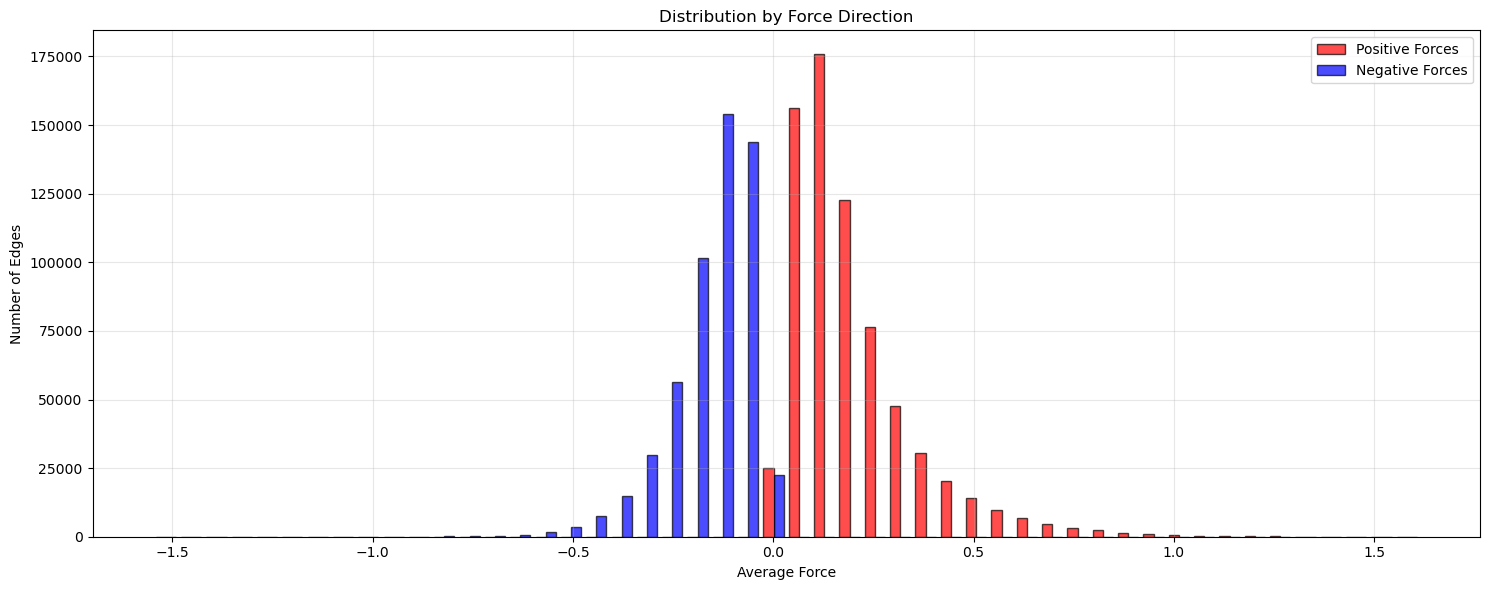

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get summary statistics for average forces
print("Average force distribution statistics:")
print(f"Total edges: {len(avg_force):,}")
print(f"Mean: {avg_force.mean():.6f}")
print(f"Median: {avg_force.median():.6f}")
print(f"Std: {avg_force.std():.6f}")
print(f"Min: {avg_force.min():.6f}")
print(f"Max: {avg_force.max():.6f}")

# Calculate percentiles
percentiles = [50, 75, 90, 95, 99, 99.5, 99.9]
print(f"\nPercentile analysis:")
for p in percentiles:
    threshold = np.percentile(np.abs(avg_force), p)
    count_above = sum(np.abs(avg_force) >= threshold)
    percentage = (count_above / len(avg_force)) * 100
    print(f"{p}th percentile: {threshold:.6f} ({count_above:,} edges = {percentage:.2f}%)")

# Plot distribution
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# Separate positive and negative forces
positive_forces = avg_force[avg_force > 0]
negative_forces = avg_force[avg_force < 0]

axes.hist([positive_forces, negative_forces], bins=50, alpha=0.7, 
              color=['red', 'blue'], label=['Positive Forces', 'Negative Forces'], edgecolor='black')
axes.set_xlabel('Average Force')
axes.set_ylabel('Number of Edges')
axes.set_title('Distribution by Force Direction')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()